# Amazon Reviews Modelling Using BERT with Noisy Labels

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
!pip install --upgrade pyarrow

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pd.options.display.max_rows = None
seed=40

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Amazon Reviews Dataset

In [4]:
rn.seed(a=40)
review = pd.read_csv('../input/amazon-product-reviews/Reviews.csv')
review.shape

(568454, 10)

In [5]:
review.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [6]:
def score_round(x):
    if x>=3:
        return 1
    else: 
        return 0
review['review_score']= review.Score.apply(score_round)
review = review.rename(columns={'Text':'review_text'})
df=review.copy()

In [7]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [8]:
zeroes=df[review['review_score']==0].head(30000)
ones=df[review['review_score']==1].head(20000)

In [9]:
d=pd.concat([zeroes,ones])

In [10]:
d.head()

Id   ProductId          UserId     ProfileName  HelpfulnessNumerator  \
1    2  B00813GRG4  A1D87F6ZCVE5NK          dll pa                     0   
3    4  B000UA0QIQ  A395BORC6FGVXV            Karl                     3   
12  13  B0009XLVG0   A327PCT23YH90              LT                     1   
16  17  B001GVISJM  A3KLWF6WQ5BNYO  Erica Neathery                     0   
26  27  B001GVISJM  A3RXAU2N8KV45G          lady21                     0   

    HelpfulnessDenominator  Score        Time  \
1                        0      1  1346976000   
3                        3      2  1307923200   
12                       1      1  1339545600   
16                       0      2  1348099200   
26                       1      1  1332633600   

                                 Summary  \
1                      Not as Advertised   
3                         Cough Medicine   
12  My Cats Are Not Fans of the New Food   
16                            poor taste   
26                       Nasty No flavor   

                                          review_text  review_score  
1   Product arrived labeled as Jumbo Salted Peanut...             0  
3   If you are looking for the secret ingredient i...             0  
12  My cats have been happily eating Felidae Plati...             0  
16  I love eating them and they are good for watch...             0  
26  The candy is just red , No flavor . Just  plan...             0

In [11]:
df['review_score'].value_counts()

1    486417
0     82037
Name: review_score, dtype: int64

In [12]:
df=d.copy()
df=df.sample(frac=1).reset_index(drop=True)
df.head()
import pandas as pd
import numpy as np
num_rows_to_shuffle = int(0.5 * len(df))
np.random.seed(0)  
indices_to_shuffle = np.random.choice(df.index[1:], size=num_rows_to_shuffle, replace=False)

In [13]:
len(indices_to_shuffle)

25000

In [14]:
d=df.copy()

In [15]:
d['review_score'].value_counts()

0    30000
1    20000
Name: review_score, dtype: int64

In [16]:
for idx in indices_to_shuffle:
    if df['review_score'].loc[idx]==1:
        df.at[idx,'review_score']=0
    elif df['review_score'].loc[idx]==0:
        df.at[idx,'review_score']=1
    else:
        print('no invalid value')

In [17]:
df['review_score'].value_counts()

0    25052
1    24948
Name: review_score, dtype: int64

In [18]:
review=df.copy()

In [19]:
# review.review_score.replace("positive" , 1 , inplace = True)
# review.review_score.replace("negative" , 0 , inplace = True)

In [20]:
review.review_text = review.review_text.astype('str')
review.Summary = review.Summary.astype('str')

# 3. Analysis and Visualization

In [21]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


<AxesSubplot:xlabel='review_score', ylabel='count'>

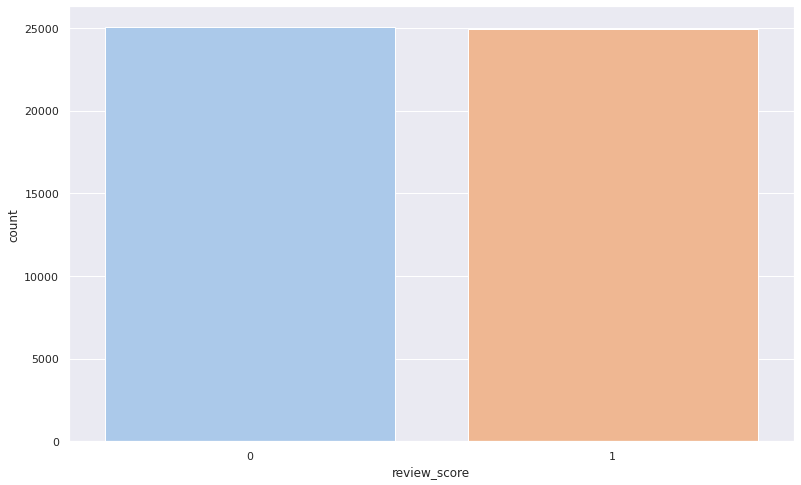

In [22]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

In [23]:
review['review_text'] = review['review_text'].str.replace(' br ','')

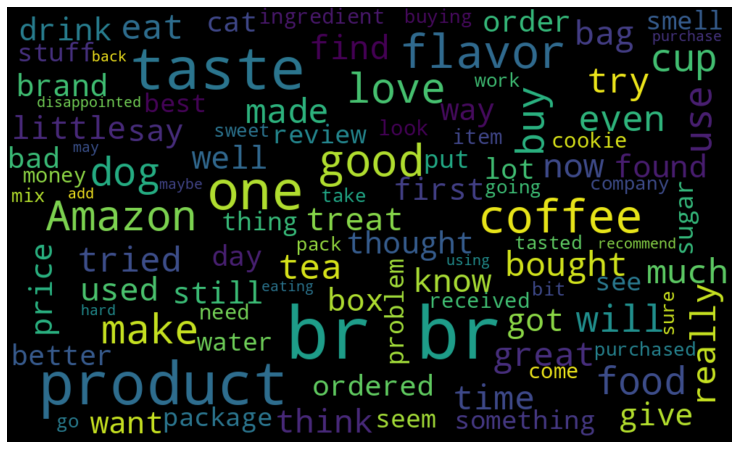

In [24]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [25]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

# 4. Data Cleaning For Sentiment Processing

In [31]:
review['review_text'] = review['review_text'].str.replace(' br ','')

In [32]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Null values Cleaning

In [33]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

### Duplicate Values Removing

In [34]:
review = review.drop_duplicates(keep='first')

In [35]:
review.shape

(50000, 11)

In [36]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [37]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [38]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [39]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [40]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [41]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [42]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [43]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [44]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [45]:
cleaning(review,'review_text')

In [46]:
review.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               2
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
review_text               0
review_score              0
dtype: int64

In [47]:
review[['review_text']].head(20)

review_text
0   bought hot sauce gift white elephant party wat...
1   two boys love happy munchies cheddar cheese ca...
2   happens coca cola gets involved perfectly good...
3   got put goodie bags birthday party kids spitti...
4   unfortunately much say product never made neve...
5   carabou mahogony worst tasting cup coffee ever...
6   product image misleading image tomatoes dop ce...
7   chihuahua take try eat big little mouth treats...
8   like popped corn small taste good crisp yet te...
9   gumballs look great new gumball machine unfort...
10  absolutely delicious compare mix gluten free b...
11  acid oddly benign flavor amplifiers think suga...
12  worst beef jerky ever tasted dried expected mu...
13  maltipoo pretty picky food treats absolutely h...
14  absolutely love peanut butter strawberry kind ...
15  involved cat rescue prefer give canned grain f...
16  first tried brand blend part k cup sampler pac...
17  love keurig found perfect cup coffee yet altho...
18  use ketchup packets lunches takes several mont...
19  best tasting tuna pack make opinion make great...

In [48]:
review_vis2 = review.copy()

In [49]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

<AxesSubplot:xlabel='count', ylabel='Common_words'>

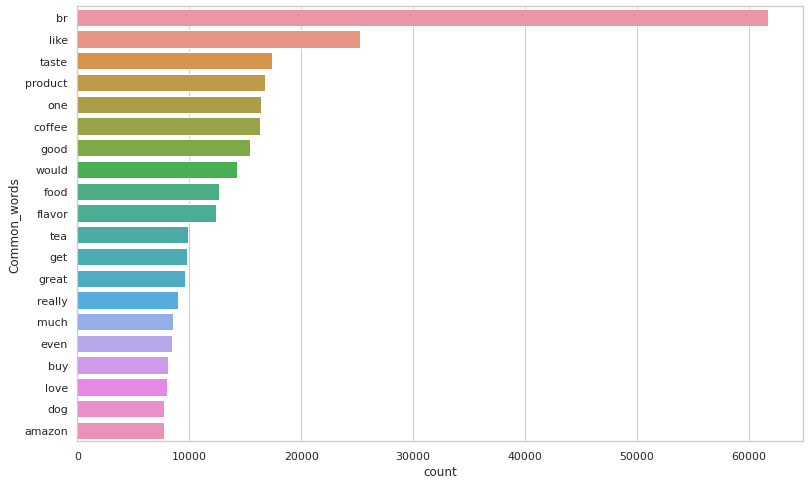

In [50]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

In [ ]:
review['review_text'] = review['review_text'].str.replace(' br ','')

# 5. BERT Tokenizing and Modelling

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()


In [52]:
reviews = review["review_text"].values.tolist()
labels = review["review_score"].tolist()

In [53]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [55]:
# Example of the tokenizer output
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 5953, 4927, 16852, 188, 15633, 1634, 1376, 6870, 1183, 5080, 2213, 1234, 5996, 1329, 2006, 16852, 17745, 4851, 6870, 8405, 1156, 1145, 4851, 2971, 3208, 7329, 3123, 7034, 1536, 5953, 1549, 5871, 5084, 6870, 3438, 1822, 20121, 1348, 2860, 1156, 3940, 5411, 1510, 13692, 172, 1611, 3970, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [56]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [57]:
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

In [58]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [60]:
history = model.fit(train_dataset.shuffle(100).batch(8),
          epochs=3,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8), verbose=1)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


3750/3750 [==============================] - 2399s 634ms/step - loss: 0.6992 - accuracy: 0.5025 - val_loss: 0.6937 - val_accuracy: 0.5037
Epoch 2/3
3750/3750 [==============================] - 2377s 634ms/step - loss: 0.6974 - accuracy: 0.5011 - val_loss: 0.6938 - val_accuracy: 0.4963
Epoch 3/3
3750/3750 [==============================] - 2377s 634ms/step - loss: 0.6971 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5015


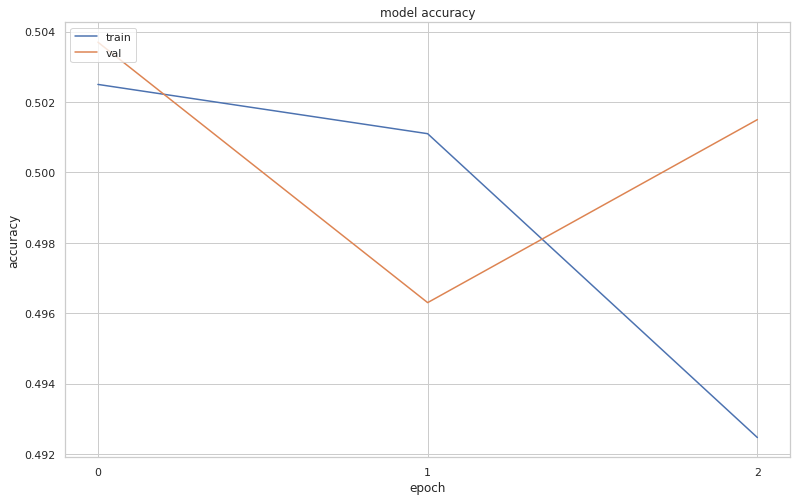

In [61]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [62]:
model.save_pretrained("./output_model")

In [63]:
loaded_model = TFBertForSequenceClassification.from_pretrained("./output_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

1250/1250 [==============================] - 248s 198ms/step - loss: 0.6931 - accuracy: 0.5041


{'loss': 0.6931273937225342, 'accuracy': 0.5041000247001648}

### We got our model's accuracy 50.41% on our holdout set (other validation set)

In [64]:
tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [65]:
cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[4595  444]
 [4515  446]]


### 50% label noise severely impacts the model's ability to correctly classify instances, resulting in a confusion matrix with a high rate of false predictions and challenges in achieving accurate performance metrics like precision and recall.

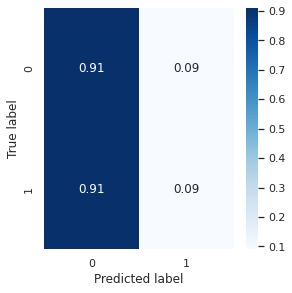

In [66]:
cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [67]:
tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)
f1score = (2*precision*recall) / (precision + recall)

print("recall score:", recall)
print("precision score:", precision)
print("F1-Score:",f1score)

recall score: 0.91
precision score: 0.5
F1-Score: 0.6453900709219857


### An F1-Score of 0.6454 indicates that the model achieves a moderate balance between precision and recall despite the presence of 50% noisy labels in the dataset. This score reflects the model's ability to manage the classification task under challenging conditions with a significant amount of label noise.